In [ ]:
from transformers import AutoTokenizer
import torch
import os
import pandas as pd
import numpy as np
import pickle
import glob
import re
import matplotlib.pyplot as plt
from scipy import stats
from tqdm.notebook import tqdm
import seaborn as sns
from sklearn.metrics.pairwise import cosine_distances
import string
import statsmodels.api as sm
from statsmodels.formula.api import ols
import itertools
import sys
sys.path.append('/home/jianing/generation/Memory_generation')
from utils import get_segmentation_indices,segmentation_to_word_list
from utils import calculate_cross_entropy,normalize_entropy,model_to_path_dict

In [ ]:
story = 'odetostepfather'
adjusted = True
save_dir = '/home/jianing/generation/generated'
model_name = 'Llama3-8b-instruct'
model_save_dir_name = model_to_path_dict[model_name]['save_dir_name']
model_initial_char = model_to_path_dict[model_name]['initial_char']
if model_name =='Llama3.2-3b-instruct_finetuned':
    tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-3B-Instruct")
else:
    tokenizer = AutoTokenizer.from_pretrained(model_to_path_dict[model_name]['hf_name'])

moth_output_dir = os.path.join(save_dir,model_save_dir_name,'moth_stories_output')
with open(os.path.join(moth_output_dir,story,'cross_entropy.pkl'),'rb') as f:
    original_ce = pickle.load(f)
# tokenized txt 
with open(os.path.join(moth_output_dir,story,'tokenized_txt.pkl'),'rb') as f:
    tokenized_txt = pickle.load(f)
story_tokens = torch.load(os.path.join(moth_output_dir,story,'tokens.pkl'))
story_tokens = story_tokens[0,1:].cpu().detach()

segmentation_dir = '/home/jianing/generation/behavior_data/segmentation'
consensus_path = os.path.join(segmentation_dir,story,'%s_consensus.txt'%story)
with open(consensus_path,'r') as f:
    consensus_txt = f.read()
consensus_txt = consensus_txt.split('\n')
original_transcript_dir = '/home/jianing/generation/transcripts/moth_stories'
with open(os.path.join(original_transcript_dir,'%s.txt'%story),'r') as f:
    original_txt = f.read()


exclusion_dir = os.path.join('/home/jianing/generation/behavior_data/','exclusion')
exclusion_df = pd.read_csv(os.path.join(exclusion_dir,'%s_exclusion.csv'%story))
excluded_subjects = exclusion_df['excluded'].loc[exclusion_df['recall']==1].values 

timing_dir = '/home/jianing/generation/transcripts/timing'
if story =='pieman':
    timing_df = pd.read_csv('/home/jianing/generation/transcripts/pieman_timing.csv')
else:
    timing_df = pd.read_csv(os.path.join(timing_dir,'%s_timing.csv'%story))

In [3]:
if adjusted:
    pairwise_event_save_dir = os.path.join(save_dir,model_save_dir_name,'pairwise_event',story,'story_split_timing_adjusted')
    story_split_by_duration_df = pd.read_csv(os.path.join(pairwise_event_save_dir,'story_split_by_duration_df_adjusted.csv'))
else:
    pairwise_event_save_dir = os.path.join(save_dir,model_save_dir_name,'pairwise_event',story,'story_split_timing')
    story_split_by_duration_df = pd.read_csv(os.path.join(pairwise_event_save_dir,'story_split_by_duration_df.csv'))

In [4]:
event_len=story_split_by_duration_df['event_ends'] - story_split_by_duration_df['event_starts']

In [800]:
exclusion_dir = os.path.join('/home/jianing/generation/behavior_data/','exclusion')
exclusion_df = pd.read_csv(os.path.join(exclusion_dir,'%s_exclusion.csv'%story))
# subjects excluded for segmentation analysis
excluded_subjects = exclusion_df['excluded'].loc[exclusion_df['recall']==1].values 

In [802]:
excluded_subjects

array([10164749, 10164753, 10164751])

## entropy each event explains about another event 

In [803]:
with open(os.path.join(pairwise_event_save_dir,'pairwise_event_tokens.pkl'),'rb') as f:
    token_pairs_dict = pickle.load(f)
with open(os.path.join(pairwise_event_save_dir,'pairwise_event_startidx_of_second_event.pkl'),'rb') as f:
    startidx_of_second_event_dict = pickle.load(f)
with open(os.path.join(pairwise_event_save_dir,'pairwise_event_ce.pkl'),'rb') as f:
    pairwise_event_ce_dict = pickle.load(f)

In [804]:
with open(os.path.join(pairwise_event_save_dir,'event_only_ce.pkl'),'rb') as f:
    all_events_only_ce = pickle.load(f)

In [805]:
pairwise_event_explained_ce_dict = {} # I(first event;second event)
for event_pair in pairwise_event_ce_dict.keys():
    second_event = event_pair[1]
    pairwise_event_ce = pairwise_event_ce_dict[event_pair]
    startidx_of_second_event = startidx_of_second_event_dict[event_pair]
    second_event_ce = pairwise_event_ce[startidx_of_second_event:]
    assert second_event_ce.shape == all_events_only_ce[second_event].shape, 'CE shape of the same event should be the same'
    explained_ce = -torch.sum(second_event_ce-all_events_only_ce[second_event]).numpy()
    pairwise_event_explained_ce_dict[event_pair] = explained_ce

##  entropy recall explains about each event (direct concatenation, recall-event)

In [806]:
recall_explained_event_info_df = pd.read_csv(os.path.join(pairwise_event_save_dir,'recall_explained_event_ce_df.csv'))
recall_explained_event_info_df = recall_explained_event_info_df[~recall_explained_event_info_df['subject'].isin(excluded_subjects)]

In [807]:
mean_ER_intersect = recall_explained_event_info_df.groupby('event')['ER_intersect'].mean()
assert len(consensus_txt)==len(mean_ER_intersect)

## entropy each event explains about recall (direct concatenation, event-recall)

In [808]:
event_explained_recall_info_df_raw = pd.read_csv(os.path.join(pairwise_event_save_dir,'event_explained_recall_ce_df.csv'))
event_explained_recall_info_df_raw = event_explained_recall_info_df_raw[~event_explained_recall_info_df_raw['subject'].isin(excluded_subjects)]

In [809]:
mean_ER_intersect_recall_last = event_explained_recall_info_df_raw.groupby('event')['ER_intersect'].mean()
assert len(consensus_txt)==len(mean_ER_intersect_recall_last)

Text(0.05, 0.95, 'r = 0.78')

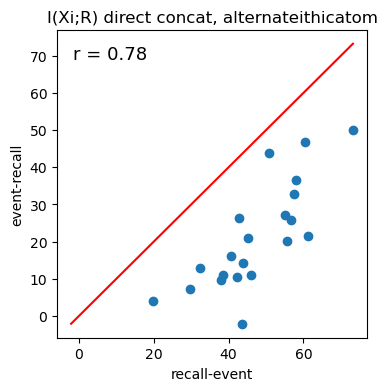

In [810]:
fig,ax = plt.subplots(figsize = (4,4))
ax.scatter(mean_ER_intersect,mean_ER_intersect_recall_last)
min_val = np.concatenate([mean_ER_intersect,mean_ER_intersect_recall_last]).min()
max_val = np.concatenate([mean_ER_intersect,mean_ER_intersect_recall_last]).max()
xx = np.linspace(min_val,max_val,100)
ax.plot(xx,xx,color = 'red')
ax.set_xlabel('recall-event')
ax.set_ylabel('event-recall')
ax.set_title('I(Xi;R) direct concat, %s'%story)
r = np.corrcoef(mean_ER_intersect,mean_ER_intersect_recall_last)[0,1]
ax.text(0.05, 0.95, 'r = %.2f'%r, ha='left', va='top', transform=plt.gca().transAxes,fontsize =13)

## entropy recall explains about each event (instruct, recall-event)

In [811]:
recall_explained_info_df = pd.read_csv(os.path.join(pairwise_event_save_dir,'instruct','recall_explained_event_ce_df.csv'))
recall_explained_info_df = recall_explained_info_df[~recall_explained_info_df['subject'].isin(excluded_subjects)]

In [812]:
mean_ER_intersect_instruct = recall_explained_info_df.groupby('event')['ER_intersect'].mean()
assert len(consensus_txt)==len(mean_ER_intersect_instruct)

## entropy each event explains about recall (instruct, event-recall)

In [813]:
event_explained_recall_info_df = pd.read_csv(os.path.join(pairwise_event_save_dir,'instruct','event_explained_recall_ce_df.csv'))
event_explained_recall_info_df = event_explained_recall_info_df[~event_explained_recall_info_df['subject'].isin(excluded_subjects)]

In [814]:
mean_ER_intersect_recall_last_instruct = event_explained_recall_info_df.groupby('event')['ER_intersect'].mean()
assert len(consensus_txt)==len(mean_ER_intersect_recall_last_instruct)

In [815]:
print(np.corrcoef(mean_ER_intersect_instruct,mean_ER_intersect_recall_last_instruct))

[[1.       0.854928]
 [0.854928 1.      ]]


In [816]:
recall_explained_info_df_rename = recall_explained_info_df.rename(columns={"ER_intersect": "recall_event"})
event_explained_recall_info_df_rename = event_explained_recall_info_df.rename(columns={"ER_intersect":"event_recall"})
ER_intersect_bothways = pd.merge(recall_explained_info_df_rename,event_explained_recall_info_df_rename,
                                 on = ['event','subject'])

In [817]:
np.corrcoef(ER_intersect_bothways['recall_event'],ER_intersect_bothways['event_recall'])

array([[1.        , 0.79953211],
       [0.79953211, 1.        ]])

In [818]:
# compare to corr with event length?
print(np.corrcoef(mean_ER_intersect_instruct,event_len))
print(np.corrcoef(mean_ER_intersect_recall_last_instruct,event_len))

[[ 1.         -0.22781631]
 [-0.22781631  1.        ]]
[[ 1.        -0.2535239]
 [-0.2535239  1.       ]]


Text(0.05, 0.95, 'r = 0.85')

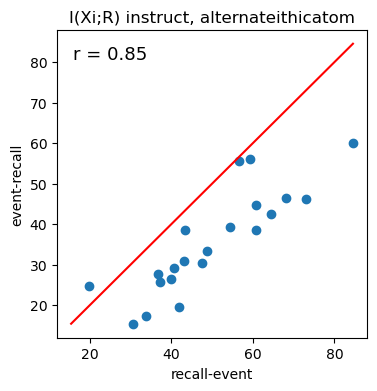

In [819]:
fig,ax = plt.subplots(figsize = (4,4))
ax.scatter(mean_ER_intersect_instruct,mean_ER_intersect_recall_last_instruct)
min_val = np.concatenate([mean_ER_intersect_instruct,mean_ER_intersect_recall_last_instruct]).min()
max_val = np.concatenate([mean_ER_intersect_instruct,mean_ER_intersect_recall_last_instruct]).max()
xx = np.linspace(min_val,max_val,100)
ax.plot(xx,xx,color = 'red')
ax.set_xlabel('recall-event')
ax.set_ylabel('event-recall')
ax.set_title('I(Xi;R) instruct, %s'%story)
r = np.corrcoef(mean_ER_intersect_instruct,mean_ER_intersect_recall_last_instruct)[0,1]
ax.text(0.05, 0.95, 'r = %.2f'%r, ha='left', va='top', transform=plt.gca().transAxes,fontsize =13)

## CRUISE and surprisal-weighted sampling

### surprisal-weighted sampling

In [820]:
conditional_event_ce = []
for idx in range(len(story_split_by_duration_df)):
    start_idx = story_split_by_duration_df['event_starts'].iloc[idx]
    end_idx = story_split_by_duration_df['event_ends'].iloc[idx]
    conditional_event_ce.append(torch.sum(original_ce[start_idx:end_idx]))
conditional_event_ce = np.array(conditional_event_ce)

In [821]:
all_events_sum_conditional = [] # the sigma term
for event_i in range(len(event_len)):
    event_i_sum = 0
    event_i_info = torch.sum(all_events_only_ce[event_i])
    event_i_conditional_ce = conditional_event_ce[event_i]
    for event_j in range(len(event_len)):
        event_j_info = torch.sum(all_events_only_ce[event_j])
        event_j_conditional_ce = conditional_event_ce[event_j]
        if event_i == event_j:
            interaction = event_i_info
        else:
            event_pair = [event_i,event_j]
            event_pair.sort()
            interaction = pairwise_event_explained_ce_dict[tuple(event_pair)]
        product = interaction/event_j_info*event_j_conditional_ce
        event_i_sum+=product
    all_events_sum_conditional.append(event_i_sum.numpy())
all_events_sum_conditional = np.array(all_events_sum_conditional)

### CRUISE number of tokens

In [829]:
all_events_sum = []
for event_i in range(len(event_len)):
    event_i_sum = 0
    event_i_info = torch.sum(all_events_only_ce[event_i])
    event_i_len = event_len[event_i]
    for event_j in range(len(event_len)):
        event_j_info = torch.sum(all_events_only_ce[event_j])
        event_j_len = event_len[event_j]
        if event_i == event_j:
            interaction = event_i_info
        else:
            event_pair = [event_i,event_j]
            event_pair.sort()
            interaction = pairwise_event_explained_ce_dict[tuple(event_pair)]
        product = interaction/event_j_info*event_j_len
        event_i_sum+=product
    all_events_sum.append(event_i_sum.numpy())
all_events_sum = np.array(all_events_sum)

### CRUISE (duration)

In [839]:
event_duration = story_split_by_duration_df['Duration']

In [ ]:
all_events_sum_by_duration = []
for event_i in range(len(event_len)):
    event_i_sum = 0
    event_i_info = torch.sum(all_events_only_ce[event_i])
    for event_j in range(len(event_len)):
        event_j_info = torch.sum(all_events_only_ce[event_j])
        event_j_duration = event_duration[event_j]
        if event_i == event_j:
            interaction = event_i_info
        else:
            event_pair = [event_i,event_j]
            event_pair.sort()
            interaction = pairwise_event_explained_ce_dict[tuple(event_pair)]
        product = interaction/event_j_info*event_j_duration
        event_i_sum+=product
    all_events_sum_by_duration.append(event_i_sum.numpy())
all_events_sum_by_duration = np.array(all_events_sum_by_duration)

## controls

In [847]:
# control2: correlation of I(Xi;R) with H(Xi)
all_events_only_sum_ce = np.array([torch.sum(t) for t in all_events_only_ce])

In [ ]:
uniform_encoding_save_dir = os.path.join(save_dir,model_save_dir_name,'uniform_encoding',story)
if not os.path.exists(uniform_encoding_save_dir):
    os.makedirs(uniform_encoding_save_dir)
uniform_encoding_df = pd.DataFrame({'H(event|prev events)':conditional_event_ce,
                                    'H(event)':all_events_only_sum_ce,
                                    'event_len':event_len,
                                    'event_duration':event_duration,
                                    'weighted_event_info':all_events_sum,
                                    'weighted_event_info_by_duration':all_events_sum_by_duration,
                                    'weighted_event_info_conditioned':all_events_sum_conditional,
                                    'mean_ER_intersect':mean_ER_intersect,
                                    'mean_ER_intersect_recall_last':mean_ER_intersect_recall_last,
                                    'mean_ER_intersect_instruct':mean_ER_intersect_instruct,
                                    'mean_ER_intersect_instruct_recall_last':mean_ER_intersect_recall_last_instruct
                         })
if adjusted:
    uniform_encoding_df.to_csv(os.path.join(uniform_encoding_save_dir,'uniform_encoding_df_even_split_adjusted.csv'),index = False)
else:
    uniform_encoding_df.to_csv(os.path.join(uniform_encoding_save_dir,'uniform_encoding_df_even_split.csv'),index = False)